In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
# Load the dataset
df = pd.read_csv('predictive_maintenance.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [10]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [15]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [22]:
# Separate numerical and categorical features
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 
                     'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

In [23]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [24]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

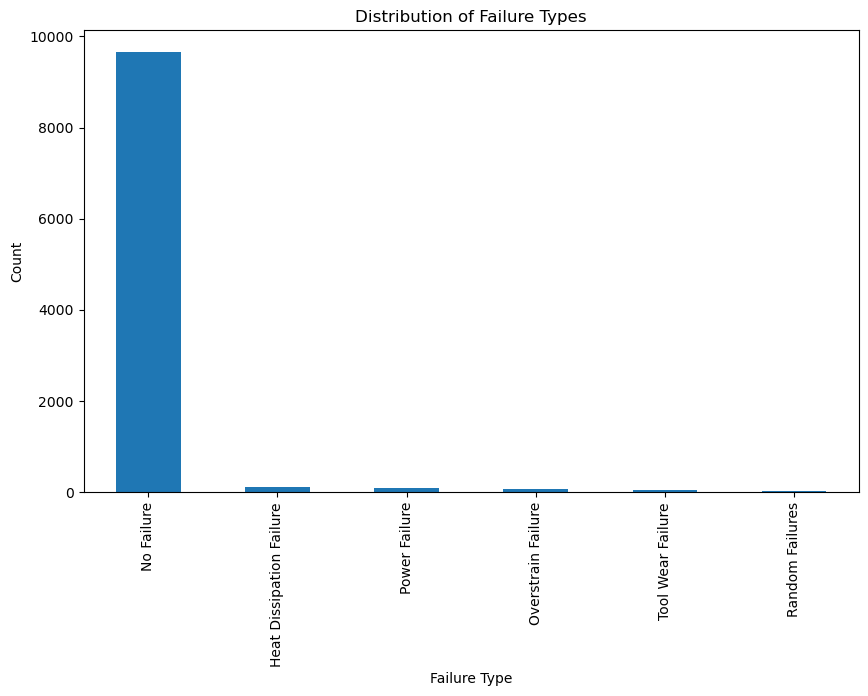

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of target classes
plt.figure(figsize=(10, 6))
df['Failure Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.show()

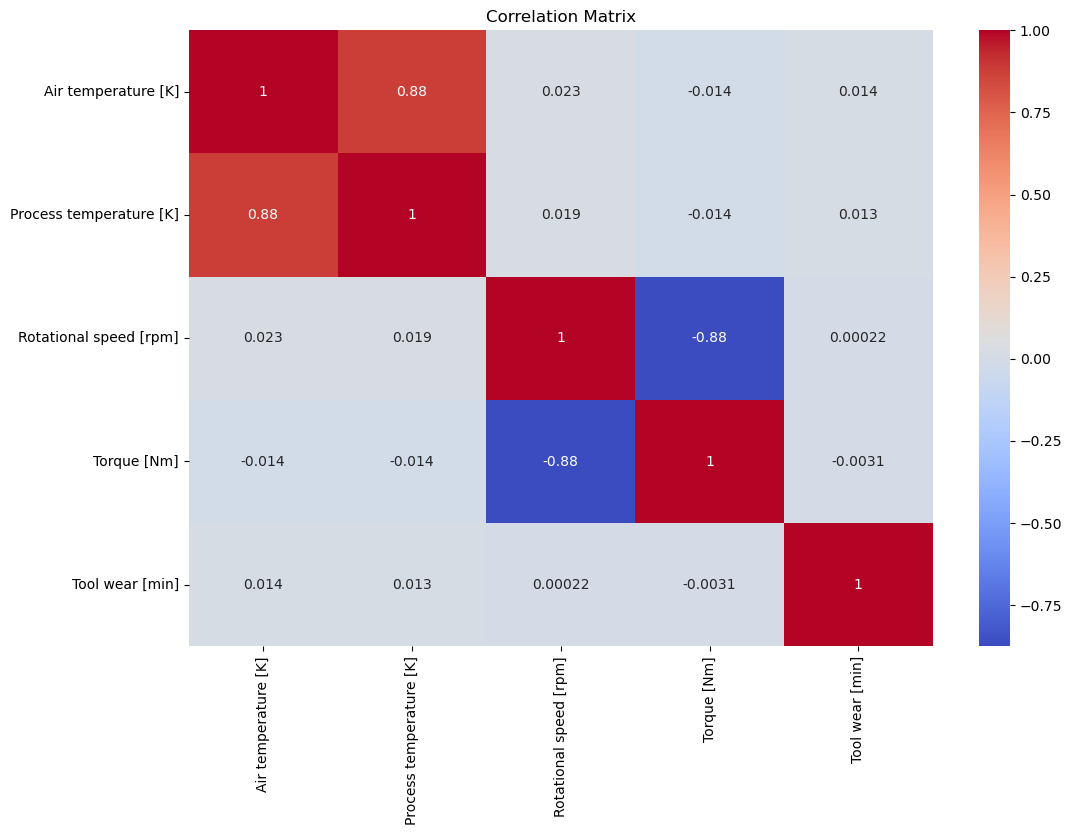

In [26]:

# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


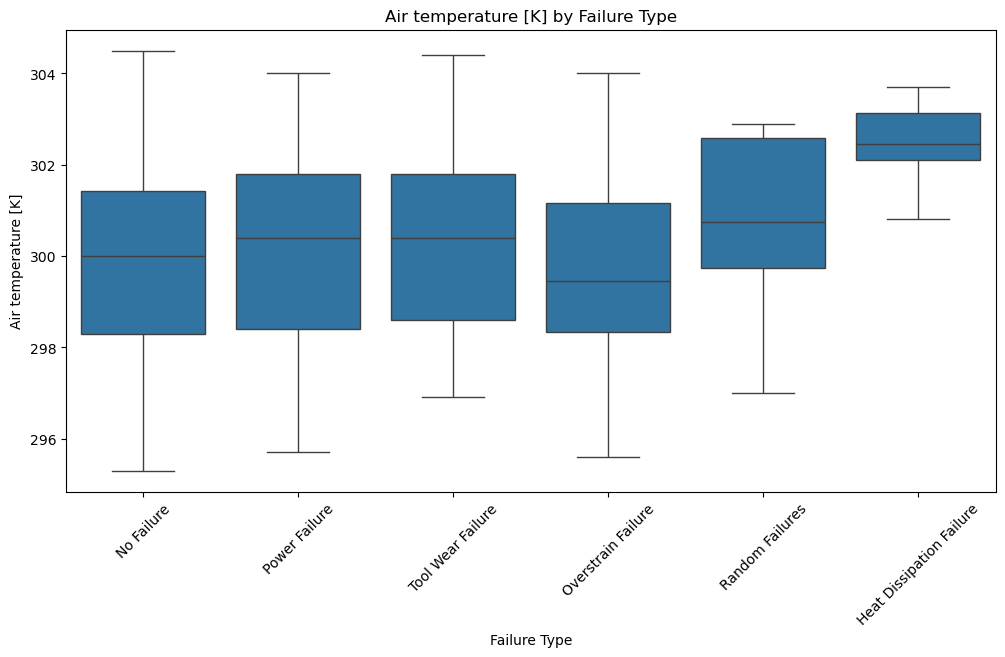

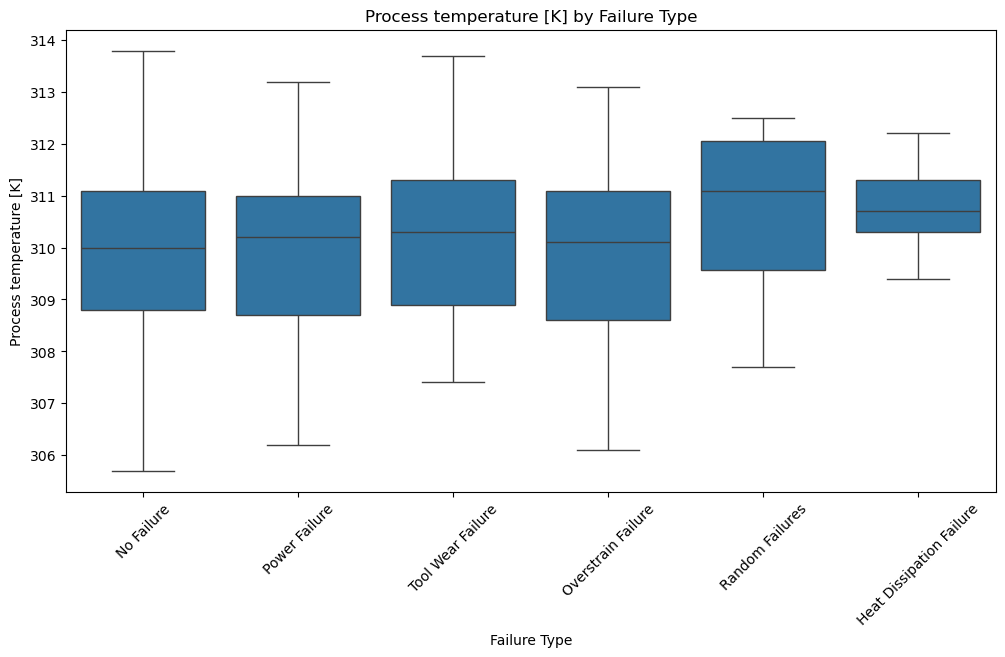

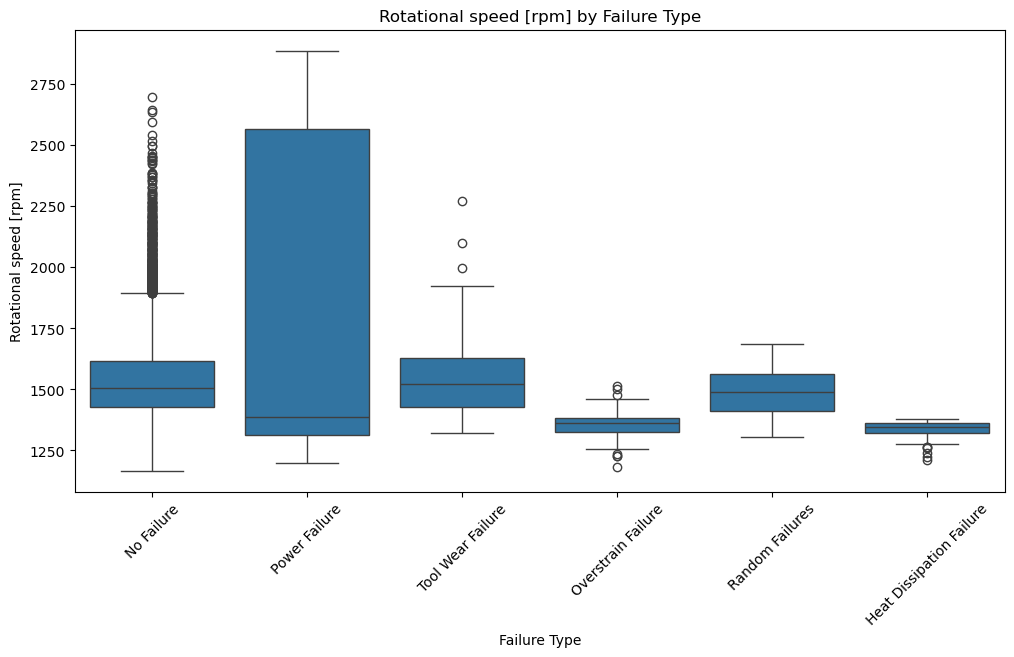

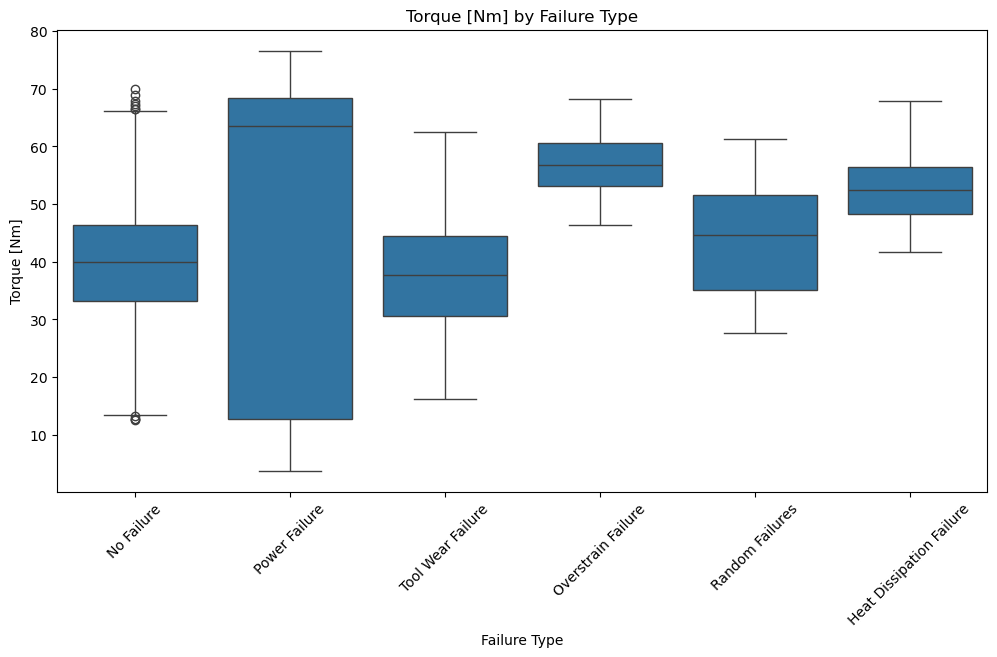

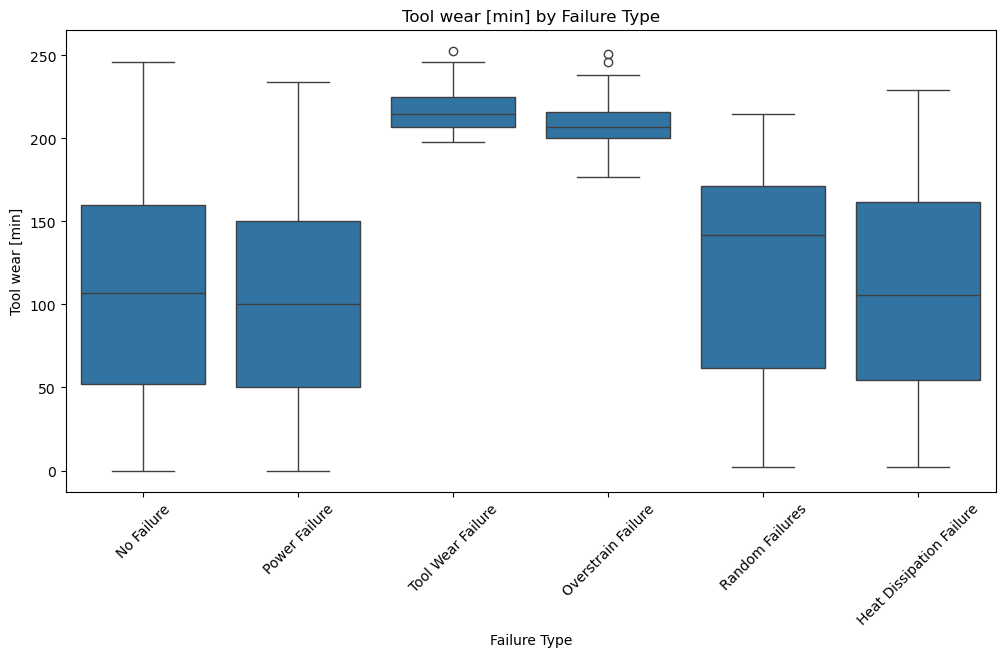

In [27]:
# Feature distributions by failure type
for feature in numerical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Failure Type', y=feature, data=df)
    plt.title(f'{feature} by Failure Type')
    plt.xticks(rotation=45)
    plt.show()

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution
print("Original class distribution:", Counter(df['Failure Type']))

# Apply SMOTE for oversampling minority classes
X = preprocessor.fit_transform(df.drop(['Target', 'Failure Type'], axis=1))
y = df['Failure Type']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18})
Resampled class distribution: Counter({'No Failure': 9652, 'Power Failure': 9652, 'Tool Wear Failure': 9652, 'Overstrain Failure': 9652, 'Random Failures': 9652, 'Heat Dissipation Failure': 9652})


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels to integers
label_encoder = LabelEncoder()
y_resampled = label_encoder.fit_transform(y_resampled)

# Convert data to PyTorch format
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Create a custom dataset
class MaintenanceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(np.array(features), dtype=torch.float32)
        self.targets = torch.tensor(np.array(targets), dtype=torch.long)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create datasets and dataloaders
train_dataset = MaintenanceDataset(X_train, y_train)
test_dataset = MaintenanceDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network
class MaintenanceNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MaintenanceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Initialize the model
input_size = X_train.shape[1]  # Number of features after preprocessing
hidden_size = 128
num_classes = len(np.unique(y_train))
model = MaintenanceNN(input_size, hidden_size, num_classes)

print("Model initialized successfully!")


Model initialized successfully!


In [41]:
# from sklearn.model_selection import GridSearchCV
# from skorch import NeuralNetClassifier

# # Define the neural net classifier with skorch
# net = NeuralNetClassifier(
#     MaintenanceNN,
#     module__input_size=input_size,
#     module__num_classes=num_classes,
#     max_epochs=20,
#     lr=0.01,
#     iterator_train__shuffle=True,
# )

# # Set up parameters for grid search
# params = {
#     'lr': [0.001, 0.01, 0.1],
#     'max_epochs': [10, 20, 30],
#     'module__hidden_size': [64, 128, 256],
#     'optimizer': [optim.Adam, optim.SGD],
# }

# # Create grid search
# gs = GridSearchCV(net, params, cv=3, scoring='f1_macro', n_jobs=-1)

# # Fit grid search
# gs.fit(X_train, y_train)

# # Best parameters and model
# print("Best parameters:", gs.best_params_)
# best_model = gs.best_estimator_
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier

# Define the neural network model
class MaintenanceNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=2):
        super(MaintenanceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Ensure input is float32
        x = x.float()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert data to appropriate dtypes
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int64)  # For classification targets

# Define the neural net classifier with skorch
net = NeuralNetClassifier(
    MaintenanceNN,
    module__input_size=input_size,
    module__num_classes=num_classes,
    max_epochs=20,
    lr=0.01,
    iterator_train__shuffle=True,
    # Add dtype specification
    dtype=torch.float32,
    # Explicitly set device
    device='cpu'
)

# Set up parameters for grid search
params = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs': [10, 20, 30],
    'module__hidden_size': [64, 128, 256],
    'optimizer': [optim.Adam, optim.SGD],
}

# Create grid search
gs = GridSearchCV(net, params, cv=3, scoring='f1_macro', n_jobs=-1)

# Fit grid search
gs.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_

/home/salah/miniconda3/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/salah/m

ValueError: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/home/salah/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/salah/miniconda3/lib/python3.12/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/salah/miniconda3/lib/python3.12/site-packages/skorch/net.py", line 1347, in fit
    self.initialize()
  File "/home/salah/miniconda3/lib/python3.12/site-packages/skorch/net.py", line 938, in initialize
    self._validate_params()
  File "/home/salah/miniconda3/lib/python3.12/site-packages/skorch/net.py", line 2079, in _validate_params
    raise ValueError(full_msg)
ValueError: __init__() got unexpected argument(s) dtype. Either you made a typo, or you added new arguments in a subclass; if that is the case, the subclass should deal with the new arguments explicitly.


In [ ]:
# Training with the best model and tracking metrics
best_hidden_size = gs.best_params_['module__hidden_size']
best_lr = gs.best_params_['lr']
best_epochs = gs.best_params_['max_epochs']
best_optimizer = gs.best_params_['optimizer']

model = MaintenanceNN(input_size, best_hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = best_optimizer(model.parameters(), lr=best_lr)

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(best_epochs):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Testing
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    
    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch+1}/{best_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

# Plot Loss/Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, best_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, best_epochs+1), test_losses, 'r-', label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy/Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, best_epochs+1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, best_epochs+1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate on train set
model.eval()
all_preds_train = []
all_targets_train = []

with torch.no_grad():
    for inputs, targets in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_train.extend(preds.cpu().numpy())
        all_targets_train.extend(targets.cpu().numpy())

# Evaluate on test set
all_preds_test = []
all_targets_test = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_targets_test.extend(targets.cpu().numpy())

# Print metrics
print("Train metrics:")
print(classification_report(all_targets_train, all_preds_train))
print("\nTest metrics:")
print(classification_report(all_targets_test, all_preds_test))

# Confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(all_targets_train, all_preds_train), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Train)')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(all_targets_test, all_preds_test), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

In [ ]:
# Define a new model with regularization
class RegularizedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch normalization
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# Initialize the regularized model
reg_model = RegularizedNN(input_size, best_hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
# Add L2 regularization through weight decay in optimizer
optimizer = best_optimizer(reg_model.parameters(), lr=best_lr, weight_decay=0.001)

# Train and evaluate the regularized model
# (Similar training loop as above, storing metrics for comparison)

# Compare regularized vs non-regularized model
plt.figure(figsize=(14, 7))
# Plot comparison of test accuracies
plt.subplot(1, 2, 1)
plt.plot(range(1, best_epochs+1), test_accuracies, 'r-', label='Standard Model')
plt.plot(range(1, best_epochs+1), reg_test_accuracies, 'g-', label='Regularized Model')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot comparison of test losses
plt.subplot(1, 2, 2)
plt.plot(range(1, best_epochs+1), test_losses, 'r-', label='Standard Model')
plt.plot(range(1, best_epochs+1), reg_test_losses, 'g-', label='Regularized Model')
plt.title('Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Compare metrics for both models
print("Standard Model Test Metrics:")
print(classification_report(all_targets_test, all_preds_test))
print("\nRegularized Model Test Metrics:")
print(classification_report(reg_all_targets_test, reg_all_preds_test))